# Import

In [1]:
from mne.io.snirf import read_raw_snirf
from get_events_from_snirf import get_events_from_snirf
from matplotlib import pyplot as plt
import numpy as np
from scipy.ndimage import gaussian_filter1d

from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier

In [2]:
from give_channels import give_channels

In [3]:
import mne_nirs

# Class

In [4]:
class SNRF:
    def __init__(self, path, hojjat = False):
        self.path = path
        self.snirf = read_raw_snirf(path)
        self.sfreq = self.snirf.info['sfreq']
        self.events = get_events_from_snirf(path, hojjat)
        self.data = self.snirf.get_data()
        self.clean()
        self.filt()
        # self.data_right, self.data_avg_right = self.plot(self.filtered_data, self.events, 'Right')
        # self.data_left, self.data_avg_left = self.plot(self.filtered_data, self.events, 'Left')
        # self.data_rest, self.data_avg_rest = self.plot(self.filtered_data, self.events, 'Rest')
    
    def drop_channels(self, good_channels):
        new_data_clean = np.zeros((len(good_channels), self.clean_data.shape[1]))
        new_data_filtered = np.zeros((len(good_channels), self.clean_data.shape[1]))
        for i, channel in enumerate(good_channels):
            index = np.where(self.clean_channels == channel)
            new_data_clean[i] = self.clean_data[index]
            new_data_filtered[i] = self.clean_data[index]
        
        self.clean_channels = good_channels
        self.clean_data = new_data_clean
        self.filtered_data = new_data_filtered
    
    def clean(self):
        nans = np.isnan(self.data)
        nans_sum = np.sum(nans, axis=1)
        nans_ids = nans_sum > 0
        self.clean_data = self.data[~nans_ids, :]
        self.clean_channels = np.array(self.snirf.ch_names)[~nans_ids]
        
    def get_duration(self, events):
        duration = events[events['Duration'].round() >0].Duration.min().round().astype(int)
        return duration
    
    def get_block_start_indexes (self):
        return (self.events.Timestamp[self.events.Block] * self.sfreq).astype(int).values
    
    def get_block_labels(self):
        return self.events[self.events['Block']]['Label'].values
    
    def get_start_indexes(self, events):
        start_indexes = ((events.Timestamp.values - 5) * self.sfreq).round().astype(int)
        return start_indexes
    
    def get_events_start_block(self, events, label):
        if label == 'Rest':
            events = events[(events.Duration > 2) & (events.Event == 'StartRest')]
        else:
            events = events[(events.BlockType == label) & (events.Event == 'StartBlock')]
        return events
    
    def get_window(self, index, start, end):
        start = index + int(self.sfreq * start)
        end = index + int(self.sfreq * end)
        return self.filtered_data[:, start:end]
    
    def get_block_windows(self, start, end):
        return np.array([self.get_window(index, start, end) for index in self.get_block_start_indexes()])
    
    def get_normalized_block_windows(self, baseline_start, baseline_end, window_start, window_end):
        baselines = self.get_block_windows(baseline_start, baseline_end)
        windows = self.get_block_windows(window_start, window_end)
        
        baseline_avg = np.mean(baselines, axis=2)
        baseline_std = np.std(baselines, axis=2)
        
        baseline_avg_rep = np.repeat(baseline_avg[:, :, np.newaxis], windows.shape[2], axis=2)
        baseline_std_rep = np.repeat(baseline_std[:, :, np.newaxis], windows.shape[2], axis=2)
        
        windows = (windows - baseline_avg_rep) / baseline_std_rep
        
        return windows
    
    def get_data(self, all_data, start_indexes, duration):
        tmp = [all_data[:, start_index:start_index + int(duration*self.sfreq)] for start_index in start_indexes]
        # print([np.shape(t) for t in tmp])
        data = np.array(tmp)
        return data
    
    def get_data_avg(self, data):
        data_avg = np.mean(data, axis=0)
        return data_avg
    
    def plot(self,all_data, all_events, label):
        events = self.get_events_start_block(all_events, label)
        duration = self.get_duration(events) + (0 if label == 'Rest' else 20 )
        start_indexes = self.get_start_indexes(events)
        data = self.get_data(all_data, start_indexes, duration)
        data_avg = self.get_data_avg(data)
        # plt.pcolor( data_avg, shading='auto', cmap='binary')
        # _plot(snirf, data_avg, duration)
        return data, data_avg
    
    def filt(self):
        self.filtered_data = gaussian_filter1d(self.clean_data, 5, axis=1)
        
    def find_channels(self, start, channels, o2):
        out = [ch for ch in channels if ch.startswith(start) and ch.endswith(o2) ]
        out = np.array(out)
        return out

    def find_channel_indexes(self, channels, filt):
        out = [i for i, ch in enumerate(channels) if ch in filt]
        out = np.array(out)
        return out
    
    def pick(self, start, o2):
        tmp = self.find_channels(start,self.clean_channels, o2)
        indexes = self.find_channel_indexes(self.clean_channels, tmp)
        return indexes    

In [5]:
def plot_signal(signal, label, sigma = 5):
    signal_filtered = gaussian_filter1d(signal, sigma)
    plt.plot(signal_filtered, label=label)
    plt.xticks(np.linspace(0, len(signal), 10), (np.linspace(0, len(signal), 10)/7.14).round().astype(int) - 5)
    plt.axvline(x=int(5*7.14))
    plt.axhline(y=0)
    # plt.fill_betweenx(y=np.linspace(np.min(signal), np.max(signal), 100), x1=int(5*7.14), x2=int(20*7.14), alpha=.5, color='skyblue')
    plt.legend()

In [6]:
def plot_base(signal, sfreq, label):
    tmp = np.mean(signal, axis=0)
    base_time = int(5*sfreq)
    tmp_base = tmp[: base_time]
    # tmp_avg = np.mean(tmp [: int(5*snirf_1.sfreq)])
    base_avg = np.mean(tmp_base) 
    base_std = np.std(tmp_base)
    # tmp = (tmp - base_avg) / base_std
    plot_signal(tmp, label, 5)

# Load File

In [7]:
path_1 = '../data_hojjat/dec_nef/1_new_full_2/test_001_S001_c7bcdc0_5.snirf'
path_2 = '../data_hojjat/dec_nef/2/test_001_S001_7d1123e_5.snirf'
path_3 = '../data_hojjat/dec_nef/3/test_001_S001_7d1123e_5.snirf'

In [8]:
snirf_1 = SNRF(path_1, True)
snirf_2 = SNRF(path_2, True)
snirf_3 = SNRF(path_3, True)

Loading /home/kernel/Desktop/py_test/project/kernel_stuff/../data_hojjat/dec_nef/1_new_full_2/test_001_S001_c7bcdc0_5.snirf
Loading /home/kernel/Desktop/py_test/project/kernel_stuff/../data_hojjat/dec_nef/2/test_001_S001_7d1123e_5.snirf
Loading /home/kernel/Desktop/py_test/project/kernel_stuff/../data_hojjat/dec_nef/3/test_001_S001_7d1123e_5.snirf


In [9]:
def get_channels_in_common(snirfs):
    base = snirfs[0]
    base_clean_channels = base.clean_channels
    l = len(snirfs)
    for i in np.arange(1, l):
        snirf = snirfs[i]
        clean_channels = snirf.clean_channels
        base_clean_channels = np.intersect1d(base_clean_channels, clean_channels)
    return base_clean_channels

In [10]:
common_channels = get_channels_in_common([snirf_1, snirf_2, snirf_3])

In [11]:
snirf_1.drop_channels(common_channels)
snirf_2.drop_channels(common_channels)
snirf_3.drop_channels(common_channels)

In [12]:
snirf_3.clean_data.shape

(1270, 4414)

In [13]:
viz_blocks_1 = snirf_1.get_normalized_block_windows(-5, 0, -5, 10)
viz_blocks_2 = snirf_2.get_normalized_block_windows(-5, 0, -5, 10)
viz_blocks_3 = snirf_3.get_normalized_block_windows(-5, 0, -5, 10)

In [14]:
viz_blocks = np.vstack([viz_blocks_1, viz_blocks_2, viz_blocks_3])

In [15]:
viz_blocks = viz_blocks_1.copy()

In [16]:
viz_blocks.shape

(160, 1270, 106)

In [17]:
from scipy.signal import find_peaks
from scipy.stats import skew
from scipy.stats import kurtosis

In [18]:
animate = [ 'Ants', 'Bat', 'Beatle', 'Bee', 'Bird', 'Butterfly', 'Cat', 'Catterpilar', 'Chicken', 'Cockroach', ...
          , 'Dog', 'Dolphin', 'Fish', 'Fly', 'Frog','Gecko', 'Giraffe', 'Grasshoper', 'GuineaPig', 'Horse', ...
          , 'Mouse', 'Peacock', 'Rabbit', 'Shark', 'Sheep', 'Snake', 'Spider', 'Turtle', 'Whale', 'Worm']
inanimate = [ 'Airplane', 'Bicycle', 'Car', 'Cellphone', 'Chair', 'Guitar', 'Hammer','Key', 'Scissor', ...
            , 'Umbrella']

In [19]:
animate_indexes = [label in animate for label in snirf_1.get_block_labels()]

In [20]:
inanimate_indexes = [label in inanimate for label in snirf_1.get_block_labels()]

In [21]:
viz_blocks.shape

(160, 1270, 106)

In [22]:
animate_blocks = viz_blocks[animate_indexes]

In [23]:
inanimate_blocks = viz_blocks[inanimate_indexes]

In [24]:
animate_blocks.shape

(120, 1270, 106)

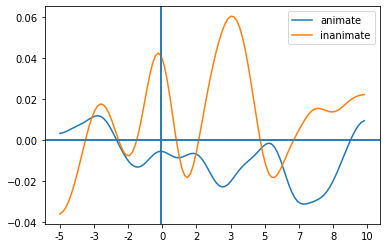

In [25]:
plot_base(animate_blocks[:, 1], sfreq=snirf_1.sfreq, label= 'animate')
plot_base(inanimate_blocks[:, 1], sfreq=snirf_1.sfreq, label= 'inanimate')

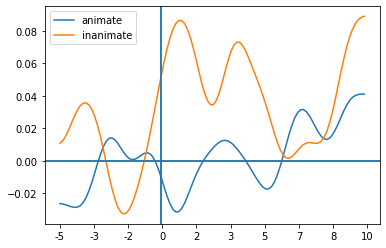

In [26]:
plot_base(animate_blocks[:, 2], sfreq=snirf_1.sfreq, label= 'animate')
plot_base(inanimate_blocks[:, 2], sfreq=snirf_1.sfreq, label= 'inanimate')

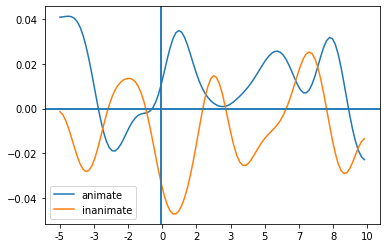

In [27]:
plot_base(animate_blocks[:, 3], sfreq=snirf_1.sfreq, label= 'animate')
plot_base(inanimate_blocks[:, 3], sfreq=snirf_1.sfreq, label= 'inanimate')

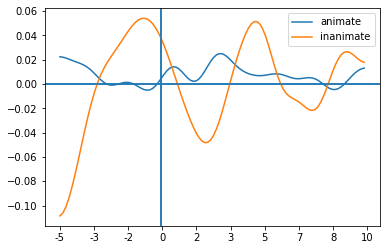

In [28]:
plot_base(animate_blocks[:, 4], sfreq=snirf_1.sfreq, label= 'animate')
plot_base(inanimate_blocks[:, 4], sfreq=snirf_1.sfreq, label= 'inanimate')

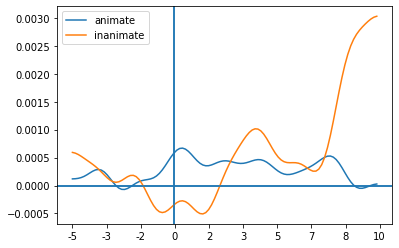

In [29]:
plot_base(np.mean(animate_blocks, axis=1), sfreq=snirf_1.sfreq, label='animate')
plot_base(np.mean(inanimate_blocks, axis=1), sfreq=snirf_1.sfreq, label='inanimate')

In [44]:
def extract_features(blocks):
    means = np.mean(blocks, axis=2)
    slope = blocks[:, :, -1] - blocks[:, :, 0]
    mins = np.min(blocks, axis=2)
    maxs = np.max(blocks, axis = 2)
    # peaks, _ = find_peaks(blocks[0, 0])
    # len(peaks)
    # np.sum(hojjat[0, 0][peaks])
    skews = skew(blocks, axis=2)
    kurtosi = kurtosis(blocks, axis=2)
    features = np.stack((means, slope, mins, maxs, skews, kurtosi), axis=2)
    # print([np.shape(tmp) for tmp in [means, slope, mins, maxs, skews, kurtosi]])
    return means

In [31]:
extract_features(animate_blocks).shape

(120, 1270, 6)

# Classify

In [32]:
clf_blocks = snirf_1.get_normalized_block_windows(-5, 0, 2, 7)

In [33]:
animate_clf_blocks = viz_blocks[animate_indexes]
inanimate_clf_blocks = viz_blocks[inanimate_indexes]

In [45]:
animate_features = extract_features(animate_clf_blocks)
inanimate_features = extract_features(inanimate_clf_blocks)

In [46]:
animate_features.shape

(120, 1270)

In [47]:
# clf = tree.DecisionTreeClassifier()

X = np.vstack((animate_features, inanimate_features))
y = np.hstack((np.ones(len(animate_features)), 2*np.ones(len(inanimate_features))))

# scores = cross_val_score(clf, X[80:], y[80:], cv=5)

In [85]:
print('X', X[:, :100].shape)
print('y', y.shape)

X (160, 100)
y (160,)


In [86]:
from sklearn import linear_model
# from sklearn.linear_model.LassoCV
clf = linear_model.LassoCV(max_iter=10000)
clf.fit(X[:80, :50], y[:80])

/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:633: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0
  model = cd_fast.enet_coordinate_descent_gram(
/home/kernel/Desktop/py_test/project/venv/lib/python3.8/site-packages/sklearn/linear_model/_coord

LassoCV(max_iter=10000)

In [87]:
print(clf.coef_)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [88]:
np.sum(clf.coef_)

0.0

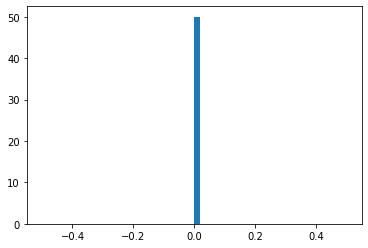

In [89]:
plt.hist(clf.coef_, bins=50);

In [102]:
from sklearn.neural_network import MLPClassifier

In [105]:
net = MLPClassifier(random_state=1, max_iter=300).fit(X[:80], y[:80])

In [107]:
net.score(X[:80], y[:80])

1.0

In [108]:
from sklearn.linear_model import Ridge

In [109]:
clf = Ridge(alpha=1.0)

In [110]:
clf.fit(X[:80], y[:80])

Ridge()

In [112]:
clf.score(X[80:], y[80:])

-1.0

In [116]:
clf.coef_[clf.coef_ != 0]

array([], dtype=float64)

In [94]:
X[81, :50].shape

(50,)

In [101]:
np.sum(clf.predict(X[81: ,:50]) - y[81:])/len(y[81:])

-0.5063291139240507

In [ ]:
clf.

In [61]:
np.unique(clf.coef_)

array([0.])

In [62]:
print(clf.intercept_)

1.0


In [42]:
animate_features.shape

(120, 1270)

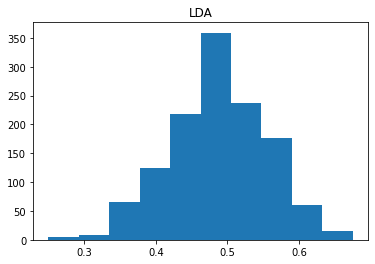

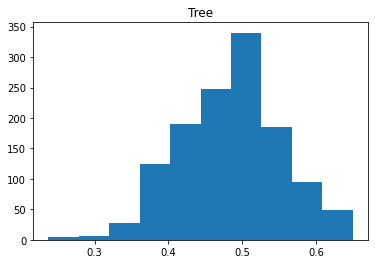

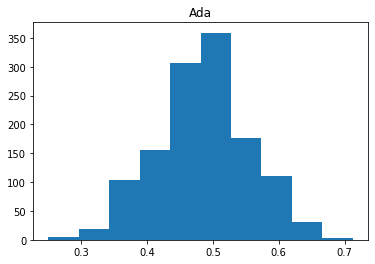

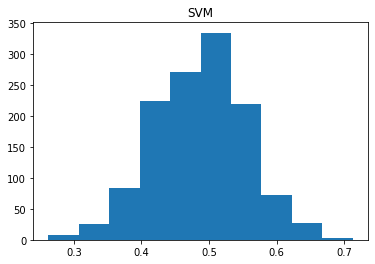

In [46]:
clfs = [LDA(), KNeighborsClassifier(n_neighbors=3), AdaBoostClassifier(n_estimators=100, random_state=0), make_pipeline(StandardScaler(), SVC(gamma='auto'))]
clf_labels = ['LDA', 'Tree', 'Ada', 'SVM']
clf_scores = []
for i in range(len(clfs)):
    clf = clfs[i]
    label = clf_labels[i]
    all_scores = np.zeros(animate_features.shape[1])
    for ch in range(animate_features.shape[1]):
        # start = ch
        # for end in ['O', 'R']:
        #     picks = snirf_1.pick(start, end)
        #     if len(picks > 0):
        animate_features_picked = animate_features[:, ch, :].reshape(animate_features.shape[0],  animate_features.shape[2])
        inanimate_features_picked = inanimate_features[:, ch, :].reshape(inanimate_features.shape[0],  inanimate_features.shape[2])

        X = np.vstack((animate_features_picked, inanimate_features_picked))
        y = np.hstack((np.ones(len(animate_features_picked)), 2*np.ones(len(inanimate_features_picked))))

        clf = tree.DecisionTreeClassifier()
        scores = cross_val_score(clf, X[80:], y[80:], cv=5)

        all_scores [ch] = np.mean(scores)
        # dic[str(snirf_1.clean_channels[ch]) ] = np.mean(scores)
    clf_scores.append(all_scores)
    plt.hist(all_scores)
    plt.title(label)
    plt.show();

In [ ]:
plt.hist(all_scores);

In [ ]:
picks = snirf_1.pick('S17', 'o')

In [ ]:
animate_features_picked = animate_features[:, picks, :].reshape(animate_features.shape[0], len(picks) * animate_features.shape[2])
inanimate_features_picked = inanimate_features[:, picks, :].reshape(inanimate_features.shape[0], len(picks) * inanimate_features.shape[2])

In [36]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score


In [ ]:
X = np.vstack((animate_features_picked, inanimate_features_picked))
y = np.hstack((np.ones(len(animate_features_picked)), 2*np.ones(len(inanimate_features_picked))))

In [ ]:
X.shape

In [ ]:
y.shape

In [ ]:
clf = LDA()
clf.fit(X, y)

In [ ]:
clf.score(X, y)

In [ ]:
scores = cross_val_score(clf, X[80:], y[80:], cv=5)

In [ ]:
scores.mean()

In [37]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
neigh = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(neigh, X[80:], y[80:], cv=5)

In [ ]:
print(scores.mean())
scores

In [38]:
from sklearn import tree

In [ ]:
clf = tree.DecisionTreeClassifier()
scores = cross_val_score(clf, X[80:], y[80:], cv=5)

In [ ]:
print(scores.mean())
scores

In [ ]:
clf.fit(X[80:], y[80:])

In [ ]:
clf.score(X[:80], y[:80])

In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
scores = cross_val_score(clf, X[80:], y[80:], cv=5)

In [ ]:
print(scores.mean())
scores

In [40]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
scores = cross_val_score(clf, X[80:], y[80:], cv=5)

In [ ]:
print(scores.mean())
scores

# GLM?

In [ ]:
import statsmodels.api as sm

In [ ]:
sm.add_constant(X).shape

In [ ]:
sm.datasets.scotland.load().endog

In [ ]:
gamma_model = sm.GLM(y, sm.add_constant(X), family=sm.families.Gamma())

In [ ]:
gamma_results = gamma_model.fit()

In [ ]:
gamma_results.params

In [ ]:
print(gamma_results.summary())

In [ ]:
np.repeat(np.ones((3, 4))[:, :, np.newaxis], 5, axis=2).shape

In [ ]:
snirf_1.get_block_windows(2, 7).shape

In [ ]:
snirf_1.get_block_labels()

In [ ]:
events = snirf_1.events
data = snirf_1.filtered_data
np.array([data[:, time:time+10] for time in events.Timestamp[events.Block].astype(int)]).shape

In [ ]:
plot_signal(snirf_1.filtered_data[4], 'asd', 7)

In [ ]:
picks_1 = snirf_1.pick('S20', 'O')
picks_1_R = snirf_1.pick('S20', 'R')
picks_2 = snirf_2.pick('S21', 'O')
picks_2_R = snirf_2.pick('S21', 'R')

In [ ]:
picks_1_00 = snirf_1.pick('S00', 'O')

In [ ]:
picks_1_12 = snirf_1.pick('S12', 'O')
picks_1_14 = snirf_1.pick('S14', 'O')
picks_1_20 = snirf_1.pick('S20', 'O')
picks_1_22 = snirf_1.pick('S22', 'O')
picks_1_28 = snirf_1.pick('S28', 'O')
picks_1_30 = snirf_1.pick('S30', 'O')
picks_1_36 = snirf_1.pick('S36', 'O')

In [ ]:
picks_1_13 = snirf_1.pick('S13', 'O')
picks_1_15 = snirf_1.pick('S15', 'O')
picks_1_21 = snirf_1.pick('S21', 'O')
picks_1_23 = snirf_1.pick('S23', 'O')
picks_1_29 = snirf_1.pick('S29', 'O')
picks_1_31 = snirf_1.pick('S31', 'O')
picks_1_37 = snirf_1.pick('S37', 'O')

In [ ]:
picks_1_37_37d0 = snirf_1.pick('S37_D37d0', 'O')

In [ ]:
snirf_2.data_avg_left[0].shape

In [ ]:
snirf_1.data_avg_left.shape

In [ ]:
tmp = np.mean(snirf_2.data_avg_left[picks_2], axis=0)
base_time = int(5*snirf_1.sfreq)
tmp_base = tmp[: base_time]
# tmp_avg = np.mean(tmp [: int(5*snirf_1.sfreq)])
base_avg = np.mean(tmp_base) 
base_std = np.std(tmp_base)
tmp = (tmp - base_avg) / base_std

In [ ]:
plt.figure(figsize=(25, 10))
plot_base(snirf_1.data_avg_right[picks_1_14], snirf_1.sfreq, snirf_1.clean_channels[pick])

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_00], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_00], snirf_1.sfreq, 'Left')
plot_base(snirf_1.data_avg_rest[picks_1_00], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_12], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_12], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_13], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_13], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_14], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_14], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_15], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_15], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_20], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_20], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_21], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_21], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_22], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_22], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_23], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_23], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_28], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_28], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_29], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_29], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_30], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_30], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_31], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_31], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_36], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_36], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_37], snirf_1.sfreq, 'Right')
plot_base(snirf_1.data_avg_left[picks_1_37], snirf_1.sfreq, 'Left')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1_12], snirf_1.sfreq, '12')
plot_base(snirf_1.data_avg_right[picks_1_14], snirf_1.sfreq, '14')
plot_base(snirf_1.data_avg_right[picks_1_20], snirf_1.sfreq, '20')
plot_base(snirf_1.data_avg_right[picks_1_22], snirf_1.sfreq, '22')
plot_base(snirf_1.data_avg_right[picks_1_28], snirf_1.sfreq, '28')
plot_base(snirf_1.data_avg_right[picks_1_30], snirf_1.sfreq, '30')
plot_base(snirf_1.data_avg_right[picks_1_36], snirf_1.sfreq, '36')

In [ ]:
plot_base(snirf_1.data_avg_left[picks_1_12], snirf_1.sfreq, '12')
plot_base(snirf_1.data_avg_left[picks_1_14], snirf_1.sfreq, '14')
plot_base(snirf_1.data_avg_left[picks_1_20], snirf_1.sfreq, '20')
plot_base(snirf_1.data_avg_left[picks_1_22], snirf_1.sfreq, '22')
plot_base(snirf_1.data_avg_left[picks_1_28], snirf_1.sfreq, '28')
plot_base(snirf_1.data_avg_left[picks_1_30], snirf_1.sfreq, '30')
plot_base(snirf_1.data_avg_left[picks_1_36], snirf_1.sfreq, '36')

In [ ]:
plot_base(snirf_1.data_avg_rest[picks_1_12], snirf_1.sfreq, '12')
plot_base(snirf_1.data_avg_rest[picks_1_14], snirf_1.sfreq, '14')
plot_base(snirf_1.data_avg_rest[picks_1_20], snirf_1.sfreq, '20')
plot_base(snirf_1.data_avg_rest[picks_1_22], snirf_1.sfreq, '22')
plot_base(snirf_1.data_avg_rest[picks_1_28], snirf_1.sfreq, '28')
plot_base(snirf_1.data_avg_rest[picks_1_30], snirf_1.sfreq, '30')
plot_base(snirf_1.data_avg_rest[picks_1_36], snirf_1.sfreq, '36')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_1], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_right[picks_1_R], snirf_1.sfreq, 'R')

In [ ]:
plot_base(snirf_1.data_avg_left[picks_1], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_left[picks_1_R], snirf_1.sfreq, 'R')

In [ ]:
plot_base(snirf_1.data_avg_right[picks_2], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_right[picks_2_R], snirf_1.sfreq, 'R')

In [ ]:
plot_base(snirf_1.data_avg_left[picks_2], snirf_1.sfreq, 'O')
plot_base(snirf_1.data_avg_left[picks_2_R], snirf_1.sfreq, 'R')

In [ ]:
plt.plot(tmp)

In [ ]:
plot_signal(np.mean(snirf_1.data_avg_left[picks_1], axis=0), 'O')
plot_signal(np.mean(snirf_1.data_avg_left[picks_1_R], axis=0), 'R')

In [ ]:
plot_signal(tmp, 'mammad', 7)

In [ ]:
snirf_1.data_avg_rest.shape

In [ ]:
print((picks_1))
print((picks_2))

In [ ]:
print(snirf_1.clean_channels[picks_1])
print(snirf_2.clean_channels[picks_2])

In [ ]:
tog = np.vstack((snirf_1.data_left[:,picks_1,:], snirf_2.data_left[:,picks_2,:]))

In [ ]:
plot_signal(signal=np.mean(np.mean(tog, axis= 0), axis=0), label='asd')

In [ ]:
plt.plot(np.mean(np.mean(tog, axis= 0), axis=0))

In [ ]:
snirf_2.data_right.shape

In [ ]:
snirf_1.data_right.shape

# Events

In [ ]:
events = get_events_from_snirf(path, False)

In [ ]:
events

# Data

In [ ]:
data = snirf.get_data()

In [ ]:
nans = np.isnan(data)
nans_sum = np.sum(nans, axis=1)
nans_ids = nans_sum > 0

In [ ]:
print(nans_ids.shape)
print(data.shape)
len(snirf.ch_names)

In [ ]:
clean_data = data[~nans_ids, :]
clean_channels = np.array(snirf.ch_names)[~nans_ids]

In [ ]:
print(clean_data.shape)
clean_channels.shape

# Channels


# Plot

In [ ]:
def get_duration(events):
    duration = events[events['Duration'].round() >0].Duration.min().round().astype(int)
    return duration

In [ ]:
def get_start_indexes(events, sampling_rate):
    start_indexes = (events.Timestamp.values*sampling_rate).round().astype(int)
    return start_indexes

In [ ]:
def get_events_start_block(events, label):
    if label == 'Rest':
        events = events[(events.Duration > 2) & (events.Event == 'StartRest')]
    else:
        events = events[(events.BlockType == label) & (events.Event == 'StartBlock')]
    return events

In [ ]:
def get_data(all_data, start_indexes, duration):
    tmp = [all_data[:, start_index:start_index + (duration*sampling_rate).round().astype(int)] for start_index in start_indexes]
    # print([np.shape(t) for t in tmp])
    data = np.array(tmp)
    return data

In [ ]:
def get_data_avg(data):
    data_avg = np.mean(data, axis=0)
    return data_avg

In [ ]:
def _plot(snirf, data, duration):
    times = range(duration)
    channel_names = [x['ch_name'] for x in snirf.info['chs']]
    is_hbo = np.array([1 if channel_name.endswith(
       'HbO') else 0 for channel_name in channel_names], dtype=bool)
    channel_locations_3d = [x['loc'][:3] for x in snirf.info['chs']]

    _, ax = plt.subplots(ncols=2, figsize=(10, 5))
    ax[0].pcolor(times, np.arange(np.sum(is_hbo)), data[is_hbo, :], shading='nearest')
    ax[0].set_title('HbO')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Channel number')
    ax[1].pcolor(times, np.arange(np.sum(~is_hbo)),
                data[~is_hbo, :], shading='nearest')
    ax[1].set_title('HbR')
    ax[1].set_xlabel('Time [s]')
    # plt.show() 

In [ ]:
def plot(snirf, all_data, all_events, sampling_rate, label):
    events = get_events_start_block(all_events, label)
    duration = get_duration(events) 
    start_indexes = get_start_indexes(events, sampling_rate)
    data = get_data(all_data, start_indexes, duration)
    data_avg = get_data_avg(data)
    plt.pcolor( data_avg, shading='auto', cmap='binary')
    # _plot(snirf, data_avg, duration)
    return data, data_avg

In [ ]:
np.linspace(0, 10, 20)

In [ ]:
sampling_rate = snirf.info['sfreq']  #7.14 #8.26 #7.14

In [ ]:
data_right, data_avg_right = plot(snirf, clean_data, events, sampling_rate, 'Right')

In [ ]:
data_left, data_avg_left = plot(snirf, clean_data, events, sampling_rate, 'Left')

In [ ]:
data_rest, data_avg_rest = plot(snirf, clean_data, events, sampling_rate, 'Rest')

In [ ]:
clean_channels[:10]

In [ ]:
def find_channels(start, channels, o2):
    out = [ch for ch in channels if ch.startswith(start) and ch.endswith(o2) ]
    out = np.array(out)
    return out
def find_channel_indexes(channels, filt):
    out = [i for i, ch in enumerate(channels) if ch in filt]
    out = np.array(out)
    return out
def pick(start, channels, o2):
    tmp = find_channels(start,channels, o2)
    indexes = find_channel_indexes(channels, tmp)
    return indexes

In [ ]:
def find_channels(start, channels, o2):
    out = [ch for ch in channels if ch.startswith(start) and ch.endswith(o2) ]
    out = np.array(out)
    return out

In [ ]:
def find_channel_indexes(channels, filt):
    out = [i for i, ch in enumerate(channels) if ch in filt]
    out = np.array(out)
    return out

In [ ]:
def pick(start, channels, o2):
    tmp = find_channels(start,channels, o2)
    indexes = find_channel_indexes(channels, tmp)
    return indexes

In [ ]:
def pick_data(data, picks):
    data_pick = data[picks, :]
    return data_pick

In [ ]:
def plot_signal(signal, label, sigma = 5):
    signal_filtered = gaussian_filter1d(signal, sigma)
    plt.plot(signal_filtered, label=label)
    plt.xticks(np.linspace(0, len(signal), 10), (np.linspace(0, len(signal), 10)/7.14).round().astype(int) - 5)
    plt.axvline(x=int(5*7.14))
    plt.axhline(y=0)
    plt.fill_betweenx(y=np.linspace(np.min(signal), np.max(signal), 100), x1=int(5*7.14), x2=int(20*7.14), alpha=.5)
    plt.legend()

In [ ]:
np.linspace(-1, 1, 10)

In [ ]:
def plot_signal_pick(data, picks, label):
    data_pick = data[picks, :]
    data_avg = np.mean(data_pick, axis=0)
    plot_signal(data_avg, label)

In [ ]:
np.vstack((snirf_1.data_avg_right, snirf_2.data_avg_right)).shape

In [ ]:
pick_o = pick('S21', clean_channels, 'HbO')
pick_r = pick('S21', clean_channels, 'HbR')
pick_00 = pick('S00', clean_channels, 'HbO')

In [ ]:
pick_o_20 = pick('S20', clean_channels, 'HbO')

In [ ]:
snirf_1.data

In [ ]:
data_pick_right = pick_data(data_avg_right, pick_o)
data_pick_right_r = pick_data(data_avg_right, pick_r)
data_pick_left = pick_data(data_avg_left, pick_o)
data_pick_left_r = pick_data(data_avg_left, pick_r)
data_pick_rest = pick_data(data_avg_rest, pick_o)

In [ ]:
plot_signal_pick(data_avg_left, pick_00, 'left')
plot_signal_pick(data_avg_rest, pick_00, 'rest')
plot_signal_pick(data_avg_right, pick_00, 'right')

In [ ]:
plot_signal_pick(data_avg_left, pick_o, 'left')
plot_signal_pick(data_avg_rest, pick_o, 'rest')
plot_signal_pick(data_avg_right, pick_o, 'right')

In [ ]:
plot_signal_pick(data_avg_right, pick_o_20, '20')
plot_signal_pick(data_avg_right, pick_o, '21')

In [ ]:
plot_signal_pick(data_avg_left, pick_o_20, '20')
plot_signal_pick(data_avg_left, pick_o, '21')

In [ ]:
plot_signal_pick(data_avg_right, pick_o, 'o')
plot_signal_pick(data_avg_right, pick_r, 'r')

In [ ]:
plot_signal_pick(data_avg_left, pick_o, 'o')
plot_signal_pick(data_avg_left, pick_r, 'r')

In [ ]:
plot_signal_pick(data_avg_right, pick_o, 'o')
plot_signal_pick(data_avg_right, pick_r, 'r')

In [ ]:
plot_signal_pick(data_avg_right, pick_o, 'right')
plot_signal_pick(data_avg_left, pick_o, 'left')

In [ ]:
plot_signal_pick(data_avg_left - data_avg_rest[:, :107] , pick_o, 'left')
plot_signal_pick(data_avg_right - data_avg_rest[:, :np.shape(data_avg_right)[1]], pick_o, 'right')
# plot_signal_pick(data_avg_rest[:, :107], pick_o, 'rest')

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
np.array([[1, 2, 3], [3, 4, 5]]).shape

In [ ]:
stats, p_values = ttest_ind(data_pick_left[:, :107], data_pick_right[:, :107], axis=1)

In [ ]:
plt.bar(clean_channels[pick_o],  p_values)
plt.xticks(rotation = -89)
plt.show()

In [ ]:
# plot_signal(np.mean(data_avg_left[indexes], axis=0), 'meh')

In [ ]:
plt.plot(data_avg_right[0, :])
plt.plot(data_avg_right[2, :])
plt.xticks(np.linspace(0, len(data_avg_right[0, :]), 10), (np.linspace(0, len(data_avg_right[0, :]), 10)/sampling_rate).round().astype(int))
plt.show()

In [ ]:
print(data_right.shape)
print(data_avg_right.shape)

In [ ]:
print(data_left.shape)
print(data_avg_left.shape)

In [ ]:
signal_right = np.mean(data_avg_right, axis = 0)
signal_left = np.mean(data_avg_left, axis = 0)
# signal_rest = np.mean(data_avg_rest, axis = 0)

In [ ]:
plt.figure(figsize=(25, 10))
plot_signal(signal_right, 'right')
plot_signal(signal_left, 'left')
# plot_signal(signal_rest, 'rest')
# plt.legend()
plt.show()

In [ ]:
np.linspace(0, 10, 2)

# Filter

In [ ]:
filtered_data = gaussian_filter1d(clean_data, 5, axis=1)

In [ ]:
filtered_data.shape

# Classify

In [ ]:
data_right_filt, data_avg_right_filt = plot(snirf, filtered_data, events, sampling_rate, 'Right')
data_left_filt, data_avg_left_filt = plot(snirf, filtered_data, events, sampling_rate, 'Left')

In [ ]:
data_right_filt.shape

In [ ]:
def make_window(data, index, window_length):
    wind = data[:, :, index: index+window_length]
    return wind

In [ ]:
def window_to_feature(window):
    [times, channels, points] = np.shape(window)
    # features = np.ones((times, channels * 3))
    _mean = np.mean(window, axis = 2)
    _min = np.min(window, axis = 2)
    _max = np.max(window, axis = 2)
    features = np.hstack((_mean, _min, _max))
    # features[:, 3:] = data[:]
    return features

In [ ]:
def make_x_y(features):
    shape = np.shape(features)
    X = np.vstack(features)
    y = np.hstack([(i+1) * np.ones(shape[1]) for i in range(len(features))])
    return X, y

In [ ]:
def classify(X, y):
    # clf = SVC(kernel='linear', C=1, random_state=42)
    clf = MLPClassifier(random_state=1, max_iter=10000)
    # clf = OneVsRestClassifier(SVC())#.fit(X, y)
    scores = cross_val_score(clf, X, y, cv=5)
    return scores

In [ ]:
s_freq = snirf.info['sfreq']
window_length = int(1 * s_freq)
max_index = int(10 * s_freq)
scores_all = np.zeros((max_index))
picks_21 = pick('S21', clean_channels, 'HbO')
picks_20 = pick('S20', clean_channels, 'HbO')
picks_22 = pick('S22', clean_channels, 'HbO')
picks = np.hstack(( picks_22))
for i in range(max_index):
    window_left = make_window(data_left_filt[:, picks, :], i, window_length)
    window_right = make_window(data_right_filt[:, picks, :], i, window_length)
    feature_left = window_to_feature(window_left)
    feature_right = window_to_feature(window_right)
    X, y = make_x_y([feature_left, feature_right])
    scores = classify(X, y)
    scores_all [i] = scores.mean()

In [ ]:
plot_signal(scores_all, 'accuracy')

In [ ]:
y

# T Test

In [ ]:
np.nanmean(data_right, axis= 2)

In [ ]:
mean_time_right = np.nanmean(( data_right), axis = 2)
mean_time_left = np.nanmean((data_left), axis = 2)

In [ ]:
mean_time_right

In [ ]:
mean_time_right = drop_nan(mean_time_right)
mean_time_left = drop_nan(mean_time_left)

In [ ]:
mean_time_left

In [ ]:
mean_chan_right = np.mean(mean_time_right, axis= 1)
mean_chan_left = np.mean(mean_time_left, axis= 1)

In [ ]:
mean_chan_left

In [ ]:
from scipy.stats import ttest_ind

In [ ]:
ttest_ind(mean_chan_right, mean_chan_left)

In [ ]:
mean_chan_left.shape

In [ ]:
def drop_nan(data):
    clean = data[np.sum(np.isnan(data), axis=1) == 0]
    return clean

In [ ]:
tmp = np.mean(drop_nan(data_avg_rest), axis = 0)

In [ ]:
plt.plot((np.mean(drop_nan(data_avg_left), axis=0) ), label='Left')
plt.plot((np.mean(drop_nan(data_avg_right), axis= 0)), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest), axis = 0) , label='Rest')
plt.legend()
plt.title('Both')
plt.show()

In [ ]:
channel_names = [x['ch_name'] for x in snirf.info['chs']]
is_hbo = np.array([1 if channel_name.endswith(
       'HbO') else 0 for channel_name in channel_names], dtype=bool)

In [ ]:
plt.plot(np.mean(drop_nan(data_avg_left[is_hbo]), axis=0), label='Left')
plt.plot(np.mean(drop_nan(data_avg_right[is_hbo]), axis= 0), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest[is_hbo]), axis = 0), label='Rest')
plt.legend()
plt.title('HBO')
plt.show()

In [ ]:
plt.plot(np.mean(drop_nan(data_avg_left[~is_hbo]), axis=0), label='Left')
plt.plot(np.mean(drop_nan(data_avg_right[~is_hbo]), axis= 0), label='Right')
plt.plot(np.mean(drop_nan(data_avg_rest[~is_hbo]), axis = 0), label='Rest')
plt.legend()
plt.title('HBR')
plt.show()

In [ ]:
np.mean(data_avg_left, axis=0)

In [ ]:
duration_right = get_duration(events_right)
start_index_right = get_start_indexes(events_right, 8.26)

In [ ]:
data_right = np.array([data[:, start_index:start_index + duration_right] for start_index in start_index_right])

In [ ]:
data_right_avg = np.mean(data_right, axis=0)

In [ ]:
plot(snirf, data_right_avg, duration_right)